Note to use `cartopy` you need to install via conda, so create a conda env with cartopy and set up a jupyter kernel for it.

In [3]:
import os

import h5py
import numpy as np

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm

import sys
sys.path.insert(1, '../')

#from utils.weighted_acc_rmse import unlog_tp

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

era5_f = h5py.File('/global/cfs/cdirs/m4134/pscratch/precip/total_precipitation/out_of_sample/2018.h5', 'r')
ifs_f = h5py.File('/global/cfs/cdirs/m4134/pscratch/precip/tigge/total_precipitation/2018.h5', 'r')

gan_f = h5py.File('/global/cfs/cdirs/dasrepo/jpduncan/weatherbenching/ERA5_generative/inf_gan_decay/inference_ensemble/control/ens_autoregressive_predictions_control_tp_ckpt_best_binned_log_l1.h5', 'r')
l1_f = h5py.File('/global/cfs/cdirs/dasrepo/jpduncan/weatherbenching/ERA5_generative/inf_l1_only_afno_wind/inference_ensemble/control/ens_autoregressive_predictions_control_tp_ckpt_best.h5', 'r')
fcn_f = h5py.File('/global/cfs/cdirs/dasrepo/shashank/fcn/precip/autoregressive_predictions_tp.h5')

lat = 90. - np.arange(720) * 180./720
lon = np.arange(1440)*360/1440 - 180.
full_extent = (0., 360., -90, 90.)
print(gan_f['seq_pred_tp'].shape)

(178, 41, 1, 720, 1440)


176


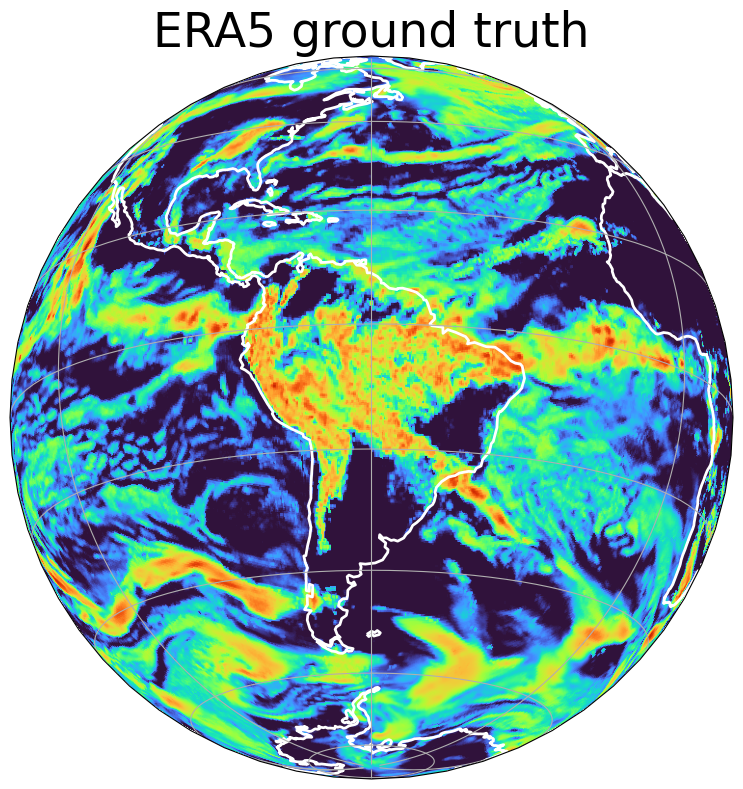

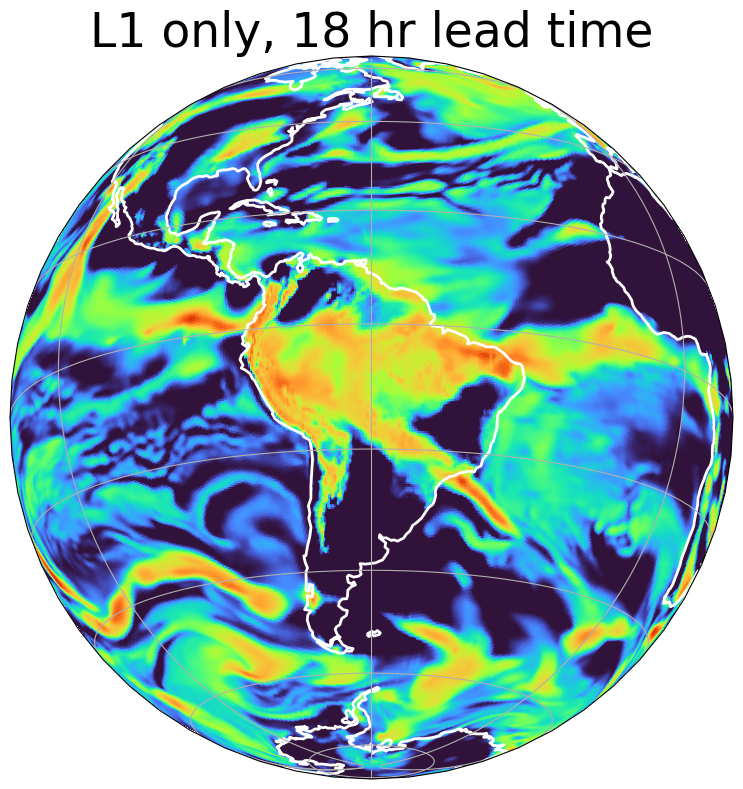

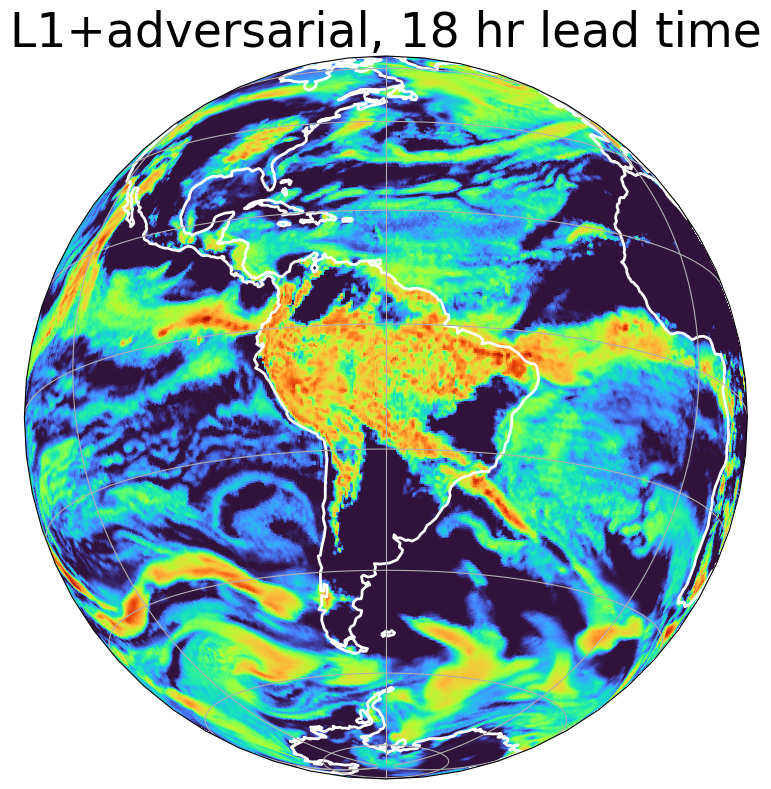

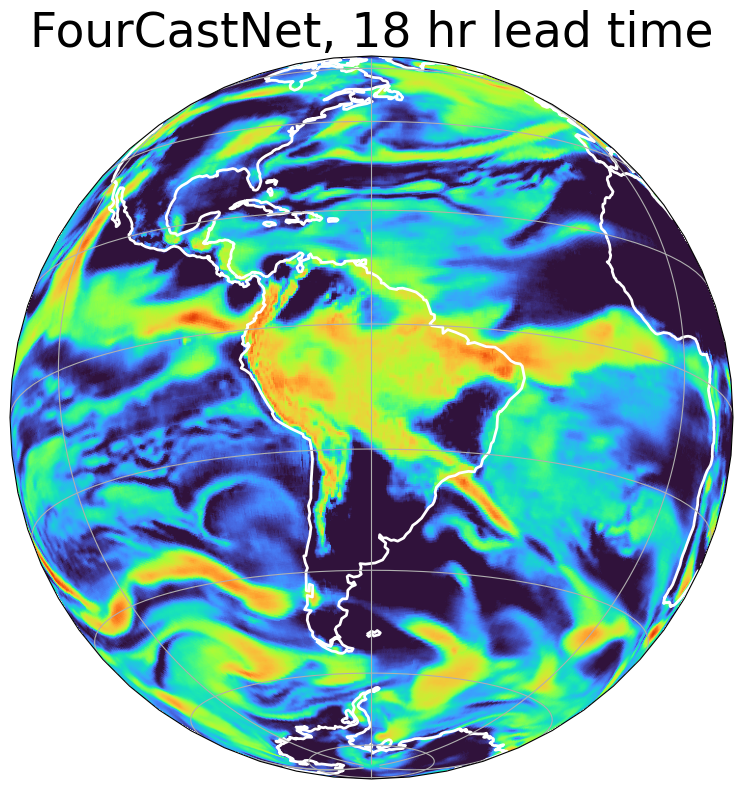

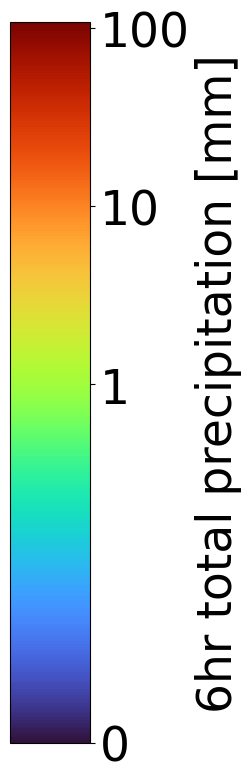

In [28]:
idx = 22
ic = int(gan_f['ics'][idx])
print(ic)
fcstep = 3
window = (-120, -0.001, -60, 30)
lonlo, lonhi, latlo, lathi = window 
proj = ccrs.PlateCarree()
axproj = ccrs.Orthographic(300, -15)
axproj._threshold /= 100.
outdir = '/global/cfs/cdirs/m4134/pharring/plots/'
fs = 34


'''
plt.figure(figsize=(12,8))
ax = plt.axes(projection=proj())
field = np.log1p(era5_f['tp'][ic+fcstep,:,:]/1e-5)
sc = np.abs(field).max()
ax.set_global()
ax.coastlines(color='white')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
ax.imshow(field, extent=full_extent, transform=proj(*pargs), cmap='turbo', norm=Normalize(0, sc))
ax.add_patch(mpatches.Rectangle(xy=[lonlo, latlo], 
                                width=lonhi-lonlo, 
                                height=lathi-latlo, 
                                facecolor=(1,1,1,0.0), 
                                edgecolor='red', 
                                lw=3, 
                                transform=proj()))
plt.title('ERA5 ground truth', fontsize=20)
plt.tight_layout()
#plt.savefig(outdir+'era5_full.pdf')
plt.show()
'''
fields = [np.log1p(era5_f['tp'][ic+fcstep,:,:]/1e-5), 
          l1_f['seq_pred_tp'][idx,fcstep,0], 
          gan_f['seq_pred_tp'][idx,fcstep,0],
          np.log1p(fcn_f['predicted'][idx,fcstep,0]/1e-5)
         ]
labels = ['ERA5 ground truth', 'L1 only', 'L1+adversarial', 'FourCastNet']

for i, field in enumerate(fields):
    plt.figure(figsize=(8,8))
    ax = plt.axes(projection=axproj)
    field = fields[i]
    if i == 0:
        sc = np.abs(field).max()
    ax.set_global()
    ax.coastlines(color='white', lw=2)
    gl = ax.gridlines(draw_labels=False)
    gl.top_labels = False
    gl.left_labels = False
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    ax.imshow(field, extent=full_extent, transform=proj, cmap='turbo', norm=Normalize(0, sc))
    
    #ax.add_patch(mpatches.Rectangle(xy=[lonlo, latlo], 
    #                                width=lonhi-lonlo, 
    #                                height=lathi-latlo, 
    #                                facecolor=(1,1,1,0.0), 
    #                                edgecolor='red', 
    #                                lw=3, 
    #                                transform=proj1))
    
    lab = '%s, %d hr lead time'%(labels[i], 6*fcstep) if i>0 else labels[i]
    plt.title(lab, fontsize=fs)
    plt.tight_layout()
    plt.savefig(outdir+'globe%d.pdf'%i)
    plt.show()


from matplotlib.ticker import LogFormatter
a = np.array([[0,sc]])
plt.figure(figsize=(1, 12))
img = plt.imshow(a, cmap="turbo")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
formatter = LogFormatter(10, labelOnlyBase=False) 
cb = plt.colorbar(orientation="vertical", cax=cax, ticks=np.log1p(np.array([0,1,10,100])/1e-2), format=formatter)
cb.ax.set_yticklabels(['0', '1', '10', '100'], fontsize=fs)
plt.ylabel('6hr total precipitation [mm]', fontsize=fs)
plt.savefig(outdir+"colorbar.pdf", bbox_inches='tight')

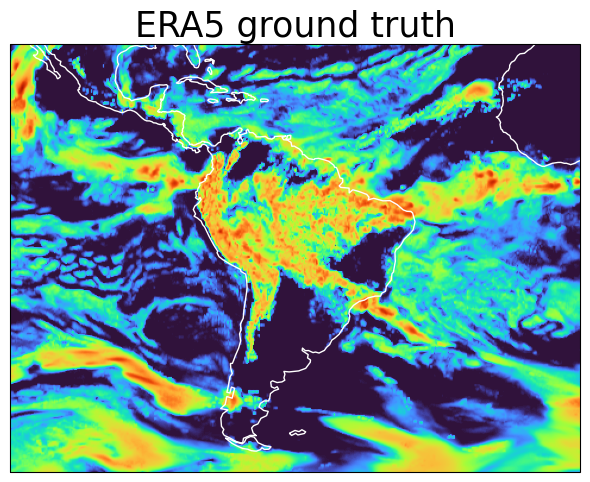

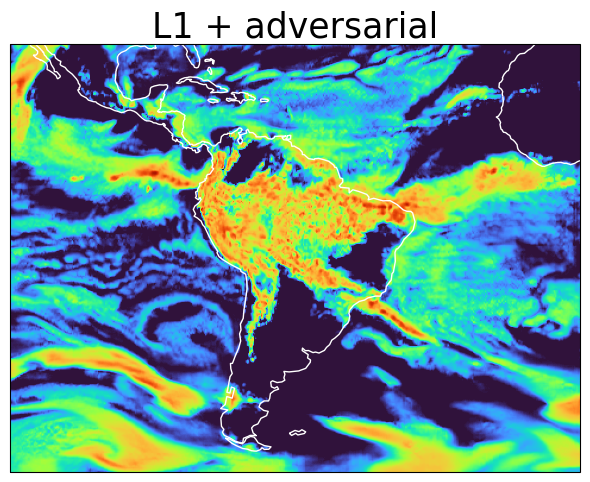

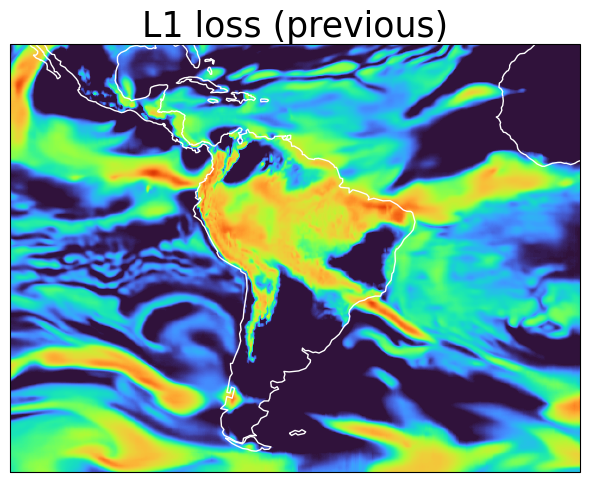

In [32]:
def lon2idx(l):
    rolled = ((l + 360)%360)
    return int(rolled*1440/360)

def lat2idx(l):
    rolled = 90 - l
    return int(rolled*720/180)
clonlo, clonhi = map(lon2idx, [lonlo, lonhi])
clathi, clatlo = map(lat2idx, [latlo, lathi])
fs=25

era5_crop = np.log1p(era5_f['tp'][ic+fcstep,clatlo:clathi,clonlo:clonhi]/1e-5)

plt.figure(figsize=(6,6))
ax = plt.axes(projection=proj)
ax.coastlines(color='white')
ax.imshow(era5_crop, extent=window, transform=proj, cmap='turbo', norm=Normalize(0, sc))
plt.title('ERA5 ground truth', fontsize=fs)
plt.tight_layout()
plt.savefig(outdir+'era5_crop.pdf')
plt.show()

names = ['L1 + adversarial', 'L1 loss (previous)']
for i, model_f in enumerate([gan_f, l1_f]):
    crop = model_f['seq_pred_tp'][idx,fcstep,0,clatlo:clathi,clonlo:clonhi]
    plt.figure(figsize=(6,6))
    ax = plt.axes(projection=proj)
    ax.coastlines(color='white')
    ax.imshow(crop, extent=window, transform=proj, cmap='turbo', norm=Normalize(0, sc))
    plt.title(names[i], fontsize=fs)
    plt.tight_layout()
    #plt.savefig(outdir+'crop%02d.pdf'%i)
    plt.show()

In [33]:
def compute_spectra(field, ch=0):
    data_truth = (np.asarray(data_truth))
    data_pred = (np.asarray(data_pred))

    # Z500_truth = np.squeeze(data_truth[:,:,ch,:,:])
    # Z500_pred = np.squeeze(data_pred[:,:,ch,:,:])
    Z500_truth = np.squeeze(np.sqrt(data_truth[:,:,0,:,:]**2 + data_truth[:,:,1,:,:]**2))
    Z500_pred = np.squeeze(np.sqrt(data_pred[:,:,0,:,:]**2 + data_pred[:,:,1,:,:]**2))

    # print(Z500_truth.shape, Z500_pred.shape)
    dt_sample = 1;
    total_t = 40

    Z_fft_pred = np.zeros([int(total_t/dt_sample),int(np.size(midlat,0)),int(np.size(Z500_pred,2)/2)+1])
    Z_fft_truth = np.zeros([int(np.size(midlat,0)),int(np.size(Z500_truth,2)/2)+1])

    for t_idx,k in enumerate(range(0,total_t,dt_sample)):
        for lat_idx,i in enumerate(midlat):  
            Z_fft_pred[t_idx,lat_idx,:] = np.abs(np.fft.rfft(np.squeeze(Z500_pred[k,i,:])))   
    Z_fft_pred_mean = np.squeeze(np.mean(Z_fft_pred,axis =1))    

    for lat_idx,i in enumerate(midlat):  
        Z_fft_truth[lat_idx,:] = np.abs(np.fft.rfft(np.squeeze(Z500_truth[0,i,:])))
    Z_fft_truth_mean = np.mean(Z_fft_truth,axis=0)
    
    return Z_fft_truth_mean, Z_fft_pred_mean, Z_fft_pred

In [47]:
Nsamp=178
scale = 1e3
fcstep = 3
band = None #[-30,30] # set to None for full domain

qs = 100
qlim = 4
qcut = 1

def quantiles(x, latband=None):
    if len(x.shape)<4:
        x = np.expand_dims(x, 1)
    if latband is not None:
        lathi, latlo = map(lat2idx, latband)
    else:
        lathi, latlo = x.shape[-2], 0
    x = x[:,:,latlo:lathi,:]
    n, c, h, w = x.shape
    qtile = 1. - np.logspace(-qlim, -qcut, num=qs)
    return np.quantile(x.reshape((n,c,h*w))*scale, q=qtile, axis=-1).squeeze()

tot_grid = era5_f['tp'][gan_f['ics'][:Nsamp].astype(int)+fcstep].sum(axis=0, keepdims=True) # total precip over ICs in 2018
tot_grid = np.expand_dims(tot_grid, 0)
bins = np.logspace(-2.1, 2.1, num=50, endpoint=True)

def fractional_contrib(x, tot=None, latband=None):
    if len(x.shape)<4:
        x = np.expand_dims(x, 1)
    if tot is None:
        tot = x.sum(axis=0, keepdims=True)
    if latband is not None:
        lathi, latlo = map(lat2idx, latband)
    else:
        lathi, latlo = x.shape[-2], 0
    x = x[:,:,latlo:lathi,:]
    tot = tot[:,:,latlo:lathi,:]
    frac = x/(tot+eps)
    h, e = np.histogram(x*scale, bins=bins, weights=frac)
    div = x.shape[-2]*x.shape[-1]
    return h/div, e


era5 = era5_f['tp'][gan_f['ics'][:Nsamp].astype(int)+fcstep]
P_era5 = quantiles(era5, latband=band)
mean_era5 = P_era5.mean(axis=1)
std_era5 = P_era5.std(axis=1)

ifs = ifs_f['tp'][gan_f['ics'][:Nsamp].astype(int)//2][:,fcstep:fcstep+1]
P_ifs = quantiles(ifs, latband=band)
mean_ifs = P_ifs.mean(axis=1)
std_ifs = P_ifs.std(axis=1)

fcn = fcn_f['predicted'][:Nsamp][:,fcstep]
P_fcn = quantiles(fcn, latband=band)
mean_fcn = P_fcn.mean(axis=1)
std_fcn = P_fcn.std(axis=1)

eps=1e-5
gan = eps*np.expm1(gan_f['seq_pred_tp'][:Nsamp,fcstep,:,:])
P_gan = quantiles(gan, latband=band)
mean_gan = P_gan.mean(axis=1)
std_gan = P_gan.std(axis=1)

l1 = eps*np.expm1(l1_f['seq_pred_tp'][:Nsamp,fcstep,:,:])
P_l1 = quantiles(l1, latband=band)
mean_l1 = P_l1.mean(axis=1)
std_l1 = P_l1.std(axis=1)

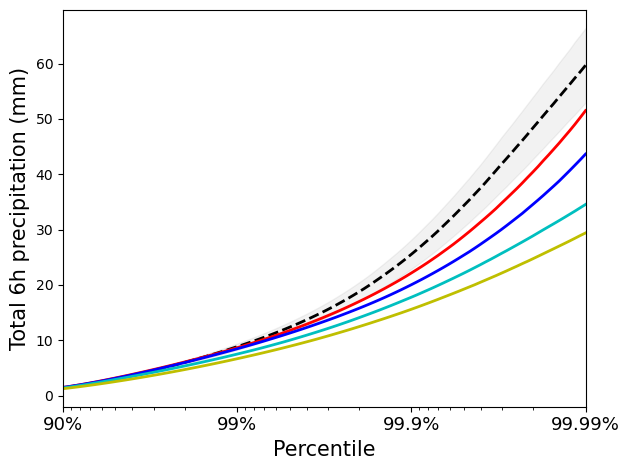

In [49]:
fs=15

#f, axs = plt.subplots(2,1)

plt.figure()
ax = plt.gca() #axs[0]
qtiles = np.logspace(-qlim, -qcut, num=qs)
ax.plot(qtiles, mean_era5, 'k--', label='ERA5', lw=2)
ax.fill_between(qtiles, mean_era5+std_era5, mean_era5-std_era5, alpha=0.05, color='k')
ax.plot(qtiles, mean_gan, 'r-', label='FourCastNet', lw=2)
#ax.fill_between(qtiles, mean_gan+std_gan, mean_gan-std_gan, alpha=0.05, color='r')
ax.plot(qtiles, mean_ifs, 'b-', label='IFS', lw=2)
#ax.fill_between(qtiles, mean_ifs+std_ifs, mean_ifs-std_ifs, alpha=0.05, color='b')
ax.plot(qtiles, mean_l1, 'c-', label='L1 only', lw=2)
ax.plot(qtiles, mean_fcn, 'y-', label='L1 only', lw=2)
ax.set_xlim((qtiles[-1], qtiles[0]))
ax.set_xscale('log')
ax.set_xticks(ticks=10.**np.arange(-1,-qlim - 1, -1))
ax.set_xticklabels(labels=['%g%%'%(100.*(1. - 10.**q)) for q in np.arange(-1,-qlim - 1, -1)], fontsize=fs-2)
ax.set_xlabel('Percentile', fontsize=fs)
ax.set_ylabel('Total 6h precipitation (mm)', fontsize=fs)
#ax.legend(fontsize=fs-2)
plt.tight_layout()
plt.savefig(outdir+'quantiles.pdf')

'''
fc_era5, edges = fractional_contrib(era5, tot_grid, latband=band)
fc_ifs, edges = fractional_contrib(ifs, tot_grid, latband=band)
fc_gan, edges = fractional_contrib(gan, tot_grid, latband=band)
fc_l1, edges = fractional_contrib(l1, tot_grid, latband=band)

ax = axs[1]
bin_ctr = (edges[:-1] + edges[1:])/2
ax.plot(bin_ctr, fc_era5, 'k--', label='ERA5', lw=2)
ax.plot(bin_ctr, fc_gan, 'r-', label='FourCastNet', lw=2)
ax.plot(bin_ctr, fc_ifs, 'b-', label='IFS', lw=2)
#ax.plot(bin_ctr, fc_l1, 'c-', label='FourCastNet (L1 only)', lw=2)
ax.set_xscale('log')
ax.set_xlabel('Precip bin (mm/6hrs)', fontsize=fs)
ax.set_ylabel('Fractional contribution', fontsize=fs)
#ax.legend(fontsize=fs-2)
'''
plt.show()

In [50]:
def powerspect(x, latband=None):
    if len(x.shape)<4:
        x = np.expand_dims(x, 1)
    if latband is not None:
        lathi, latlo = map(lat2idx, latband)
    else:
        lathi, latlo = x.shape[-2], 0
    x = x[:,:,latlo:lathi,:]
    n, c, h, w = x.shape
    fft = np.fft.rfft(x, axis=-1)
    pwr = np.abs(fft).mean(axis=2)**2
    return w*np.fft.rfftfreq(w), pwr.squeeze()

def norm(x):
    return np.log1p(x/eps)


k, P_era5 = powerspect(norm(era5), latband=band)
mean_era5 = P_era5.mean(axis=0)
std_era5 = P_era5.std(axis=0)

_, P_ifs = powerspect(norm(ifs), latband=band)
mean_ifs = P_ifs.mean(axis=0)
std_ifs = P_ifs.std(axis=0)

_, P_gan = powerspect(norm(gan), latband=band)
mean_gan = P_gan.mean(axis=0)
std_gan = P_gan.std(axis=0)

_, P_l1 = powerspect(norm(l1), latband=band)
mean_l1 = P_l1.mean(axis=0)
std_l1 = P_l1.std(axis=0)

_, P_fcn = powerspect(norm(fcn), latband=band)
mean_fcn = P_fcn.mean(axis=0)
std_fcn = P_fcn.std(axis=0)

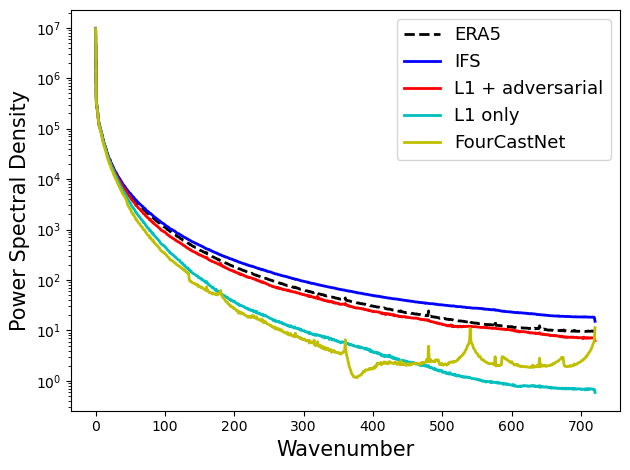

In [51]:
fs=15

plt.figure()
ax = plt.gca()
ax.plot(k, mean_era5, 'k--', label='ERA5', lw=2)
#ax.fill_between(k, mean_era5+std_era5, mean_era5-std_era5, alpha=0.05, color='k')
ax.plot(k, mean_ifs, 'b-', label='IFS', lw=2)
ax.plot(k, mean_gan, 'r-', label='L1 + adversarial', lw=2)
ax.plot(k, mean_l1, 'c-', label='L1 only', lw=2)
ax.plot(k, mean_fcn, 'y-', label='FourCastNet', lw=2)
ax.set_yscale('log')
#ax.set_ylim((1e-8, 1e0))
ax.set_xlabel('Wavenumber', fontsize=fs)
ax.set_ylabel('Power Spectral Density', fontsize=fs)
ax.legend(fontsize=fs-2)
plt.tight_layout()
plt.savefig(outdir+'powerspect.pdf')
plt.show()

In [52]:
tot_grid = era5_f['tp'][gan_f['ics'][:Nsamp].astype(int)+fcstep].sum(axis=0, keepdims=True) # total precip over ICs in 2018
tot_grid = np.expand_dims(tot_grid, 0)
bins = np.logspace(-2.1, 2.1, num=50, endpoint=True)

def fractional_contrib(x, tot=None, latband=None):
    if len(x.shape)<4:
        x = np.expand_dims(x, 1)
    if tot is None:
        tot = x.sum(axis=0, keepdims=True)
    if latband is not None:
        lathi, latlo = map(lat2idx, latband)
    else:
        lathi, latlo = x.shape[-2], 0
    x = x[:,:,latlo:lathi,:]
    tot = tot[:,:,latlo:lathi,:]
    frac = x/(tot+eps)
    h, e = np.histogram(x*scale, bins=bins, weights=frac)
    div = x.shape[-2]*x.shape[-1]
    return h/div, e

fc_era5, edges = fractional_contrib(era5, tot_grid, latband=band)
fc_ifs, edges = fractional_contrib(ifs, tot_grid, latband=band)
fc_gan, edges = fractional_contrib(gan, tot_grid, latband=band)
fc_l1, edges = fractional_contrib(l1, tot_grid, latband=band)
fc_fcn, edges = fractional_contrib(fcn, tot_grid, latband=band)

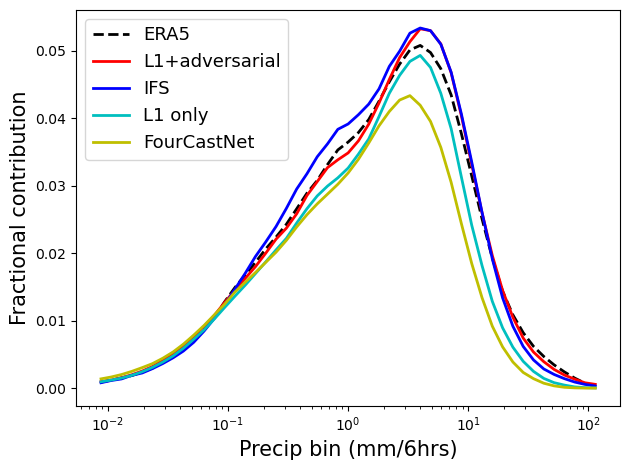

1.0095125959960423 1.0413839969850072


In [56]:
fs=15

plt.figure()
ax = plt.gca()
bin_ctr = (edges[:-1] + edges[1:])/2
ax.plot(bin_ctr, fc_era5, 'k--', label='ERA5', lw=2)
ax.plot(bin_ctr, fc_gan, 'r-', label='L1+adversarial', lw=2)
ax.plot(bin_ctr, fc_ifs, 'b-', label='IFS', lw=2)
ax.plot(bin_ctr, fc_l1, 'c-', label='L1 only', lw=2)
ax.plot(bin_ctr, fc_fcn, 'y-', label='FourCastNet', lw=2)
ax.legend(fontsize=fs-2)
ax.set_xscale('log')
ax.set_xlabel('Precip bin (mm/6hrs)', fontsize=fs)
ax.set_ylabel('Fractional contribution', fontsize=fs)#ax.legend(fontsize=fs-2)
plt.tight_layout()
plt.savefig(outdir+'fractional.pdf')
plt.show()

e5 = fc_era5.sum()
print(fc_gan.sum()/e5, fc_ifs.sum()/e5)